In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [2]:
links = pd.read_csv('data/links.csv')
links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [3]:
movies = pd.read_csv('data/movies.csv')
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [4]:
ratings = pd.read_csv('data/ratings.csv')
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [5]:
tags = pd.read_csv('data/tags.csv')
tags.head(2)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


In [6]:
tags['tag'].value_counts()

In Netflix queue        131
atmospheric              36
thought-provoking        24
superhero                24
funny                    23
                       ... 
Paris                     1
Simon and Garfunkel       1
Union                     1
ending                    1
Strangers on a Train      1
Name: tag, Length: 1589, dtype: int64

In [7]:
tags['movieId'].value_counts()

296     181
2959     54
924      41
293      35
7361     34
       ... 
6107      1
5878      1
5876      1
3192      1
8190      1
Name: movieId, Length: 1572, dtype: int64

Based on the above initial previewing of the dataset, there are two datsets we can use in our project, the movies and the ratings datasets. This is because these two datasets are the ones containing information on ratings, movie ids and user ids which we'll need to create a recommender system. 

In [8]:
#Previewing the datasets again
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
#Merging the two datasets on movieid
df = pd.merge(movies, ratings, on='movieId', how='left')
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


The timestamp column has no value in our analysis therefore we can proceed to drop it. 

In [11]:
#Dropping the timestamp column
df.drop(columns=['timestamp'], axis=1, inplace=True)
df.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5


In [12]:
df.isna().sum()

movieId     0
title       0
genres      0
userId     18
rating     18
dtype: int64

There are key columns(userId and rating) with missing values. We will investigate the 

In [13]:
#Dropping the columns with missing 
no_missing = df.isna().sum()
percent_missing = (df.isna().sum() * 100/len(df)).round(2)
missing_value_df = pd.DataFrame({'no_missing_values':no_missing,'percent_missing':percent_missing})
missing_value_df

,no_missing_values,percent_missing
movieId,0,0.00
title,0,0.00
genres,0,0.00
userId,18,0.02
rating,18,0.02


In [14]:
df = df.dropna()
df.isna().sum()

movieId    0
title      0
genres     0
userId     0
rating     0
dtype: int64

## Feature Engineering

In [15]:
df['release_year'] = df['title'].str.extract(r'\((\d{4})\)$', expand=False)
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').astype('Int64')
df.head()

,movieId,title,genres,userId,rating,release_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,1995
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1995
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1995
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1995
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1995


In [17]:
#Assigning the release year to decades
#Define a function to convert year into decade
def year_to_decade(year):
    if pd.isna(year):
        return None
    return int(year / 10) * 10

#Apply the function to the dataset
df['decade'] = df['release_year'].apply(year_to_decade)

#Convert the decade into a string for readability
df['decade'] = df['decade'].fillna(0).astype(int).astype(str) + 's'

df.head()

,movieId,title,genres,userId,rating,release_year,decade
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,1995,1990s
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1995,1990s
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1995,1990s
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1995,1990s
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1995,1990s


## Exploratory Data Analysis

### Distribution of ratings

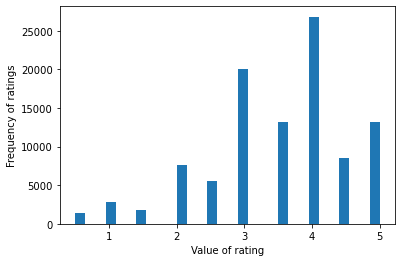

In [18]:
#Frequency of ratings
plt.hist(df['rating'],bins=30)
plt.xlabel('Value of rating')
plt.ylabel('Frequency of ratings')
plt.show()

### Genre popularity

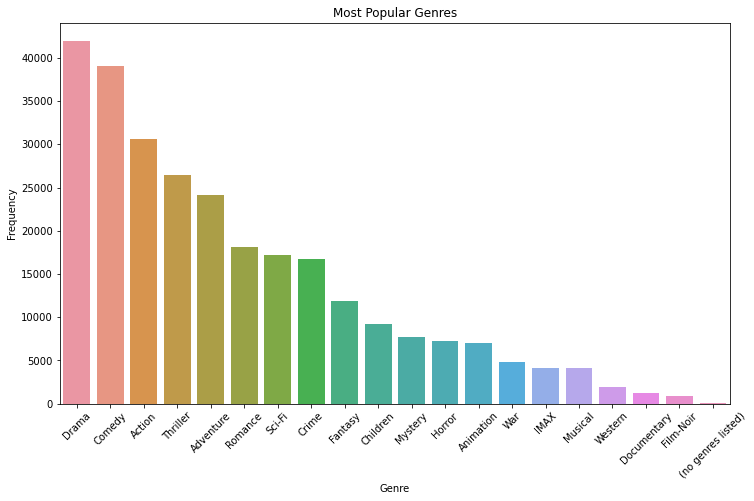

In [21]:
#Extracting genre labels from the genre column
genrelabels = set()
for i in df['genres'].str.split('|').values:
    genrelabels = genrelabels.union(set(i))
    
#Creating a function to visualize genre     
def genrecounts(df, col, labels):
    count = dict()
    for i in labels: count[i] = 0
    for value in df[col].str.split('|'):
        if type(value) == float and pd.isnull(value): continue
        for i in value: 
            if pd.notnull(i): count[i] += 1
    return count    

#Applying the function to our dataframe to extract genre count by genre labels
genre_count = genrecounts(df, 'genres', genrelabels)
genre_count

#Creating a dataframe from the genre labels and frequency
genres = pd.DataFrame(list(genre_count.items()),columns = ['Genre','Frequency'])

#Sorting values by the frequency column
genres = genres.sort_values(by=['Frequency'], ascending=False)

#Visualizing the most popular genres
plt.figure(figsize=(12,7))
sns.barplot(genres['Genre'], genres['Frequency'])
plt.title('Most Popular Genres')
plt.xticks(rotation=45);

### Movie Release by Decades

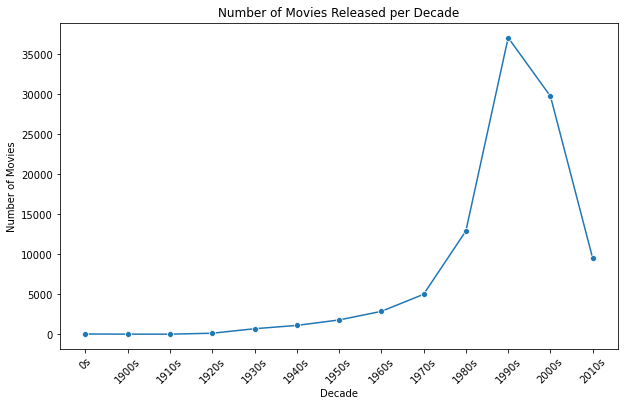

In [31]:
# Grouping by decade and counting the number of movies released
movies_per_decade = df.groupby('decade').size().reset_index(name='count')

# Plotting the counts
plt.figure(figsize=(10, 6))
sns.lineplot(data=movies_per_decade, x='decade', y='count', marker='o')
plt.title('Number of Movies Released per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45);


The number of movies produced from the 1900s if fairly low until the 1960s when it begins to rise. Movie production experiences exponentail growth from the 1970s until the highest peak in 1990s after which the number of movies begins to fall. The 2010s decades maybe missing some data as our last movie release date is in 2018. 

In [32]:
df.describe()

,movieId,userId,rating,release_year
count,100836.000000,100836.000000,100836.000000,100805.000000
mean,19435.295718,326.127564,3.501557,1994.443708
std,35530.987199,182.618491,1.042529,14.361383
min,1.000000,1.000000,0.500000,1902.000000
25%,1199.000000,177.000000,3.000000,1990.000000
50%,2991.000000,325.000000,3.500000,1997.000000
75%,8122.000000,477.000000,4.000000,2003.000000
max,193609.000000,610.000000,5.000000,2018.000000


### Number of Ratings and Average ratings per Decade

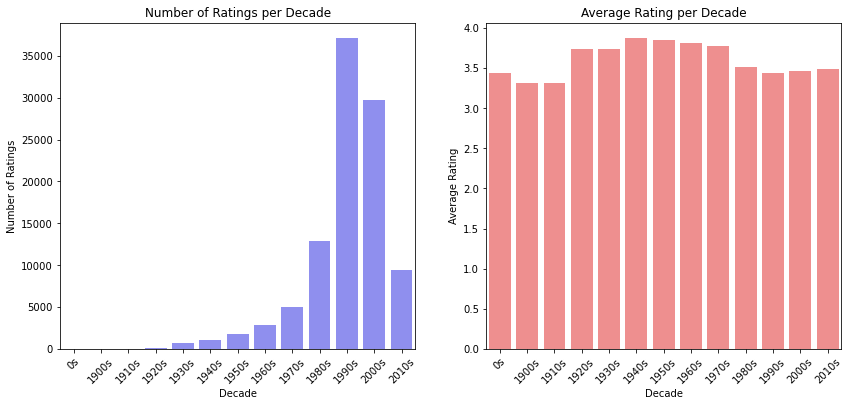

In [28]:
# Grouping by decade and calculating the average rating
ratings_stats = df.groupby('decade').agg({'rating': ['mean', 'count']}).reset_index()
ratings_stats.columns = ['decade', 'average_rating', 'number_of_ratings']

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting number of ratings per decade
sns.barplot(ax=axes[0], data=ratings_stats, x='decade', y='number_of_ratings', color='blue', alpha=0.5)
axes[0].set_title('Number of Ratings per Decade')
axes[0].set_xlabel('Decade')
axes[0].set_ylabel('Number of Ratings')
axes[0].tick_params(axis='x', rotation=45)

# Plotting average rating per decade
sns.barplot(ax=axes[1], data=ratings_stats, x='decade', y='average_rating', color='red', alpha=0.5)
axes[1].set_title('Average Rating per Decade')
axes[1].set_xlabel('Decade')
axes[1].set_ylabel('Average Rating')
axes[1].tick_params(axis='x', rotation=45);


## Modeling

In [36]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise import SVD
from surprise import accuracy

In [37]:
#Creating a new df for the columns relevant in modeling
df_model = df[['userId', 'movieId', 'rating']]

In [38]:
# Instantiating the reader 
reader = Reader(rating_scale=(0, 5))

#Loading the data into a Surprise Dataset
data = Dataset.load_from_df(df_model, reader) 


Get an average rating 
Bayesian Average

In [39]:
#Splittting the data into a train and test set with train_test_split
trainset, testset = train_test_split(data, test_size=.25)

#Printing out the number of users and items to determine which to use
print('Number of users in train set : ', trainset.n_users, '\n')
print('Number of items in train set : ', trainset.n_items, '\n')

Number of users in train set :  610 

Number of items in train set :  8759 



### KNNBasic

#### Baseline Model

We built our baseline model using KNNBasic

In [47]:
#Instantiating the Baseline Model
knn_basic = KNNBasic(random_state=42)

# Train the model on the trainset
knn_basic.fit(trainset)

# Make predictions on the testset
basic_predictions = knn_basic.test(testset)

# Evaluate the model
accuracy.rmse(basic_predictions)
accuracy.mae(basic_predictions)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9432
MAE:  0.7234


0.7233575274685778

Our baseline model gave us an RMSE of 0.9432 and MAE of 0.7234. 

In [49]:
#Instantiating the Improved Model with Specified Parameters
sim_options = {'name': 'pearson', 'user_based': True} 

knn_basic_params = KNNBasic(sim_options=sim_options)

# Train the model on the trainset
knn_basic_params.fit(trainset)

# Make predictions on the testset
knnbasic_params_preds = knn_basic_params.test(testset)

# Evaluate the model
print(accuracy.rmse(knnbasic_params_preds))
print(accuracy.mae(knnbasic_params_preds))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9684
0.968380377393534
MAE:  0.7482
0.7481891609391159


In [54]:
# Initialize the KNNBasic model
sim_options = {'name': 'cosine', 'user_based': True}  
cv_knn_basic = KNNBasic(sim_options=sim_options)

# Perform cross-validation
cv_results = cross_validate(cv_knn_basic, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the cross-validation results
print("Cross-validation Results:")
for measure in ['test_rmse', 'test_mae']:
    print(f"{measure}: {cv_results[measure].mean()}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9734  0.9694  0.9768  0.9747  0.9744  0.9737  0.0024  
MAE (testset)     0.7495  0.7446  0.7499  0.7505  0.7501  0.7489  0.0022  
Fit time          0.61    0.65    0.64    0.60    0.61    0.62    0.02    
Test time         1.63    1.60    1.59    1.58    1.54    1.59    0.03    
Cross-validation Results:
test_rmse: 0.9737478319059854
test_mae: 0.7489164523384548


Using GridSearch to get the best parameters for KNN basic model

In [56]:
#Defining the parameter grid
knn_params = {'name': ['cosine', 'pearson'],
              'user_based':[True, False], 
              'min_support':[True, False],
            'min_k' : [1, 2]}

#Applying Gridsearch to look for the best parameters
gsknnbasic = GridSearchCV(KNNBasic, knn_params, measures=['rmse', 'mae'], cv=3)
gsknnbasic.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [57]:
#Getting the best parameters and score from GridSearch
print(gsknnbasic.best_score)
print(gsknnbasic.best_params)

{'rmse': 0.9483224645617917, 'mae': 0.7297317057200798}
{'rmse': {'name': 'cosine', 'user_based': True, 'min_support': True, 'min_k': 2}, 'mae': {'name': 'cosine', 'user_based': True, 'min_support': True, 'min_k': 2}}


In [58]:
#Tuning the KNN Basic model using the GridSearch best parameters
knn_basic_tuned = KNNBasic(sim_options={'name': 'cosine', 
                                       'user_based': True, 
                                       'min_support':True, 
                                       'min_k':2, })
#Fitting the model and predicting
knn_basic_tuned.fit(trainset)
knn_tuned_preds = knn_basic_tuned.test(testset)

#Evaluating the model
accuracy.rmse(knn_tuned_preds)
accuracy.mae(knn_tuned_preds)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9688
MAE:  0.7462


0.7462305673851248

### KNN Baseline

In [59]:
#Instantiating the Model with Specified Parameters
sim_options = {'name': 'cosine', 'user_based': True}
knn_baseline = KNNBaseline(sim_options=sim_options)

# Train the model on the trainset
knn_baseline.fit(trainset)

# Make predictions on the testset
knn_base_preds = knn_baseline.test(testset)

# Evaluate the model
print(accuracy.rmse(knn_base_preds))
print(accuracy.mae(knn_base_preds))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8775
0.8774671602570294
MAE:  0.6718
0.6717868530012521


In [60]:
# Crossvalidating using the KNNBaseline model
sim_options = {'name': 'cosine', 'user_based': True}  
cv_knn_baseline = KNNBaseline(sim_options=sim_options)

# Perform cross-validation
cv_baseline_results = cross_validate(cv_knn_baseline, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the cross-validation results
print("Cross-validation Results:")
for measure in ['test_rmse', 'test_mae']:
    print(f"{measure}: {cv_baseline_results[measure].mean()}")

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8725  0.8826  0.8903  0.8761  0.8696  0.8782  0.0074  
MAE (testset)     0.6674  0.6717  0.6797  0.6704  0.6689  0.6716  0.0043  
Fit time          0.93    0.95    1.06    1.08    1.15    1.03    0.08    
Test time         2.12    2.17    2.16    2.23    2.44    2.22    0.12    
Cross-validation Results:
te

In [61]:
#Applying Gridsearch to look for the best parameters
gsknnbaseline = GridSearchCV(KNNBaseline, knn_params, measures=['rmse', 'mae'], cv=3)
gsknnbaseline.fit(data)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [62]:
#Getting the best parameters and score from GridSearch
print(gsknnbaseline.best_score)
print(gsknnbaseline.best_params)

{'rmse': 0.8743661716596941, 'mae': 0.6697679645661593}
{'rmse': {'name': 'cosine', 'user_based': True, 'min_support': True, 'min_k': 2}, 'mae': {'name': 'cosine', 'user_based': True, 'min_support': True, 'min_k': 2}}


In [64]:
#Tuning the KNN Baseline model using the GridSearch best parameters
knn_baseline_tuned = KNNBaseline(sim_options={'name': 'cosine', 
                                       'user_based': True, 
                                       'min_support':True, 
                                       'min_k':2, })
#Fitting the model and predicting
knn_baseline_tuned.fit(trainset)
knnbase_tuned_preds = knn_baseline_tuned.test(testset)

#Evaluating the model
accuracy.rmse(knnbase_tuned_preds)
accuracy.mae(knnbase_tuned_preds)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8775
MAE:  0.6718


0.6717868530012521

### SVD

In [65]:
#Fitting a basic SVD model
# Initializing the SVD model
svd_model = SVD()

# Fitting the model on the trainset
svd_model.fit(trainset)

# Making predictions on the testset
svd_preds = svd_model.test(testset)

# Evaluating the model
accuracy.rmse(svd_preds)
accuracy.mae(svd_preds)

RMSE: 0.8707
MAE:  0.6707


0.6707160045369477

Performing a GridSearch to get the best parameters

In [67]:
# Define parameter grid for GridSearchCV
svd_param_grid = {'n_factors': [70, 100, 130], 
                  'lr_all': [0.01, 0.02, 0.03],
                  'n_epochs': [30, 40, 50],
                  'reg_all': [0.05, 0.1, 0.15]}

# Perform grid search with cross-validation
gs_svd = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fit grid search on the dataset
gs_svd.fit(data)

In [68]:
#Getting the best parameters and score from GridSearch
print(gs_svd.best_score)
print(gs_svd.best_params)

{'rmse': 0.8589656751092267, 'mae': 0.6586151285044424}
{'rmse': {'n_factors': 130, 'lr_all': 0.01, 'n_epochs': 50, 'reg_all': 0.1}, 'mae': {'n_factors': 130, 'lr_all': 0.01, 'n_epochs': 50, 'reg_all': 0.1}}


In [69]:
#Instantiating the tuned model with best params
svd_tuned = SVD(n_factors=130,
               reg_all=0.1,
               n_epochs=50,
               lr_all=0.01)

#Fitting the model and predicting
svd_tuned.fit(trainset)
svd_tuned_preds = svd_tuned.test(testset)

#Printing RMSE and MAE results 
accuracy.rmse(svd_tuned_preds)
accuracy.mae(svd_tuned_preds)

RMSE: 0.8483
MAE:  0.6509


0.6509469521570307

In [73]:
df_bayes_model = df_model.copy

### Recommender System

In [ ]:
#A function to recommend top 10 movies to users given what a user has watched
def recommend_top_movies(data, user_id):
    # Assuming data is a DataFrame with columns: userid, movieid, movie title, genre, ratings
    
    # Define a Surprise Reader
    reader = Reader(rating_scale=(1, 5))

    # Load the dataset
    dataset = Dataset.load_from_df(data[['userid', 'movieid', 'ratings']], reader)

    # Train-test split (You can customize this if needed)
    trainset = dataset.build_full_trainset()

    # Initialize SVD with tuned hyperparameters
    best_svd_model = SVD(n_factors=100, reg_all=0.05)  # Example hyperparameters, replace with your tuned values

    # Fit the model on the entire dataset
    best_svd_model.fit(trainset)

    # Recommend top movies for the specified user
    top_movies = []
    movies_rated_by_user = data[data['userid'] == user_id]['movieid'].unique()
    for movie_id in trainset.all_items():
        if movie_id not in movies_rated_by_user:
            predicted_rating = best_svd_model.predict(user_id, movie_id).est
            top_movies.append((movie_id, predicted_rating))

    # Sort movies by predicted rating in descending order
    top_movies.sort(key=lambda x: x[1], reverse=True)

    # Get top 10 recommended movies
    top_10_movies = top_movies[:10]

    return top_10_movies


### Cold Start Recommender

### Final Recommender System 
